# LSTM for Stock Prediction

https://medium.com/@aniruddha.choudhury94/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

In [3]:
UOM = {'K': 1000, 'M': 1000000}

def convert_to_numeric(val):
    return float(val[:-1]) * UOM[val[-1]]

def clean_dataset(df):
    df.rename(columns={'Price':'Close', 'Vol.':'Volume'}, inplace=True)
    df.drop(columns=['Change %'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Volume'] = df['Volume'].apply(convert_to_numeric)
    df.sort_values(by=['Date'], ascending=True, inplace=True)
    df.set_index('Date', inplace=True)

dataset = pd.read_csv('data/GENTING_train_set.csv', parse_dates=True)
clean_dataset(dataset)
dataset.head(10)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,10.14,10.10,10.16,10.08,6490000.0
2011-08-16,10.10,10.18,10.24,10.02,3160000.0
2011-08-17,10.04,10.10,10.10,10.02,5410000.0
2011-08-18,9.98,10.14,10.14,9.97,5350000.0
2011-08-19,9.70,9.85,9.85,9.65,11570000.0
2011-08-22,9.51,9.68,9.69,9.49,8520000.0
2011-08-23,9.70,9.55,9.70,9.40,6520000.0
2011-08-24,9.52,9.80,9.80,9.52,5090000.0
2011-08-25,9.78,9.55,9.78,9.54,6120000.0


# Preprocessing

In [6]:
dataset.isna().any()

Close     False
Open      False
High      False
Low       False
Volume    False
dtype: bool

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1768 entries, 2011-08-15 to 2018-10-31
Data columns (total 5 columns):
Close     1768 non-null float64
Open      1768 non-null float64
High      1768 non-null float64
Low       1768 non-null float64
Volume    1768 non-null float64
dtypes: float64(5)
memory usage: 82.9 KB


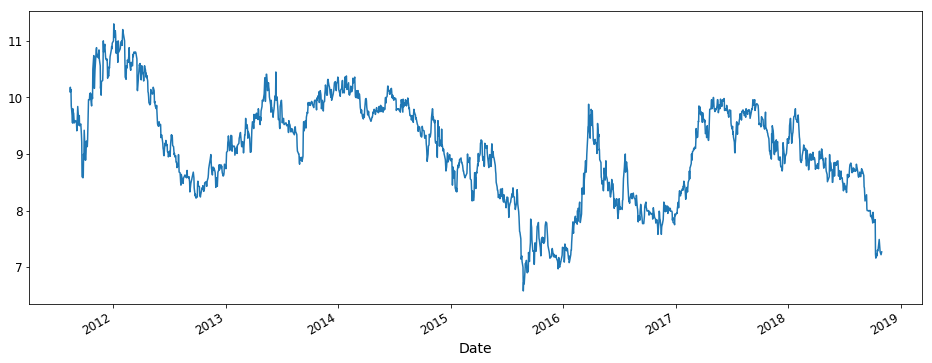

In [8]:
dataset['Open'].plot(figsize=(16,6))

In [9]:
# convert column "a" of a DataFrame
# dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)

In [10]:
# 7 day rolling mean
dataset.rolling(7).mean().head(10)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,NaN,NaN,NaN,NaN,NaN
2011-08-16,NaN,NaN,NaN,NaN,NaN
2011-08-17,NaN,NaN,NaN,NaN,NaN
2011-08-18,NaN,NaN,NaN,NaN,NaN
2011-08-19,NaN,NaN,NaN,NaN,NaN
2011-08-22,NaN,NaN,NaN,NaN,NaN
2011-08-23,9.881429,9.942857,9.982857,9.804286,6.717143e+06
2011-08-24,9.792857,9.900000,9.931429,9.724286,6.517143e+06
2011-08-25,9.747143,9.810000,9.865714,9.655714,6.940000e+06


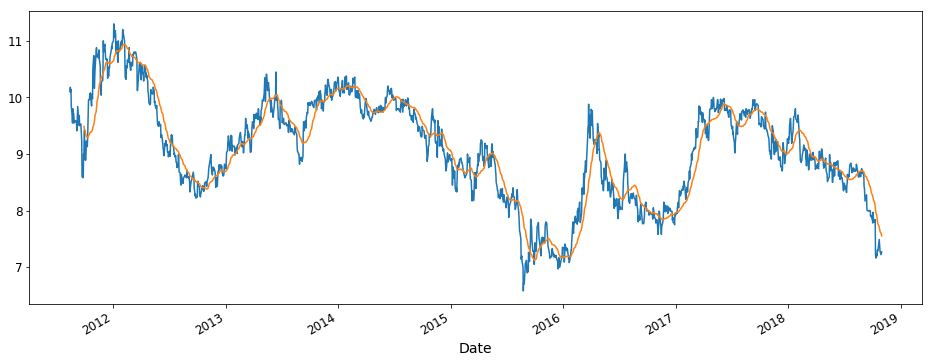

In [11]:
dataset['Open'].plot(figsize=(16,6))
dataset.rolling(window=30).mean()['Close'].plot()

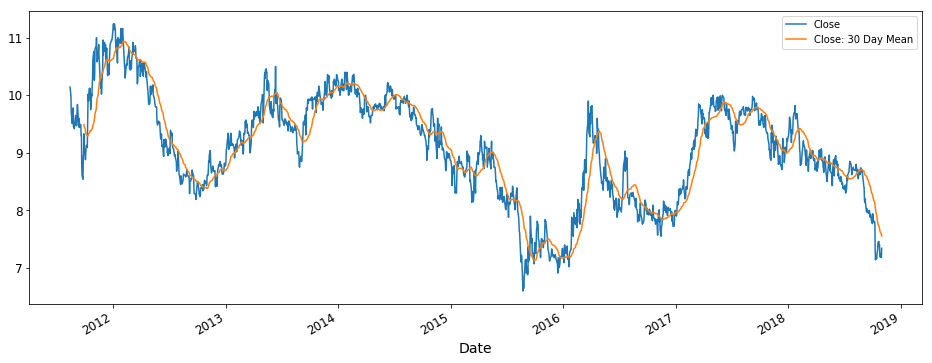

In [12]:
dataset['Close: 30 Day Mean'] = dataset['Close'].rolling(window=30).mean()
dataset[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))

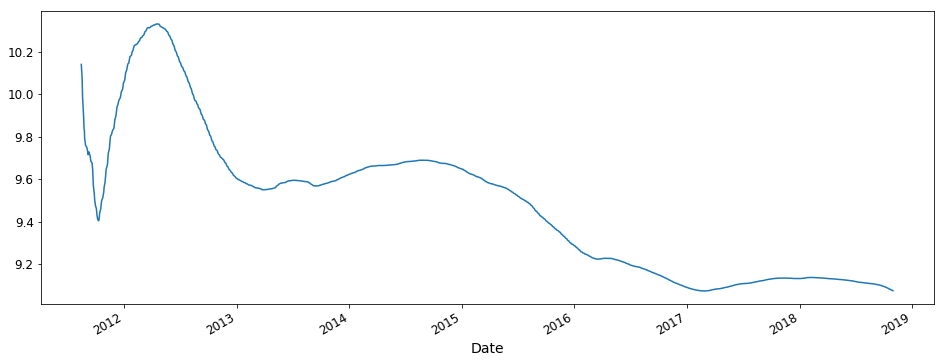

In [13]:
# Optional specify a minimum number of periods
dataset['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

# Training

In [14]:
training_set=dataset['Open']
training_set=pd.DataFrame(training_set)

In [15]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [16]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# print(len(training_set))

In [17]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
# Initialising the RNN
regressor = Sequential()

In [19]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [21]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1708/1708 [==============================] - 32s 19ms/step - loss: 0.0398
Epoch 2/100
1708/1708 [==============================] - 25s 15ms/step - loss: 0.0081
Epoch 3/100
1708/1708 [==============================] - 33s 19ms/step - loss: 0.0070
Epoch 4/100
1708/1708 [==============================] - 27s 16ms/step - loss: 0.0063
Epoch 5/100
1708/1708 [==============================] - 27s 16ms/step - loss: 0.0057
Epoch 6/100
1708/1708 [==============================] - 25s 14ms/step - loss: 0.0065
Epoch 7/100
1708/1708 [==============================] - 26s 15ms/step - loss: 0.0058
Epoch 8/100
1708/1708 [==============================] - 26s 15ms/step - loss: 0.0052
Epoch 9/100
1708/1708 [==============================] - 34s 20ms/step - loss: 0.0052
Epoch 10/100
1708/1708 [==============================] - 35s 20ms/step - loss: 0.0053
Epoch 11/100
1708/1708 [==============================] - 35s 20ms/step - loss: 0.0048
Epoch 12/100
1708/1708 [============================

In [24]:
dataset_test = pd.read_csv('data/GENTING_test_set.csv', parse_dates=True)
clean_dataset(dataset_test)

In [25]:
dataset_test.head()

,Close,Open,High,Low,Volume
Date,,,,,
2018-11-01,7.40,7.34,7.43,7.24,1730000.0
2018-11-02,7.20,7.45,7.78,7.20,25910000.0
2018-11-05,6.74,6.53,6.96,6.35,36450000.0
2018-11-07,6.74,6.80,6.93,6.70,12300000.0
2018-11-08,6.76,6.85,6.85,6.73,14210000.0


In [26]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2018-11-01 to 2019-01-18
Data columns (total 5 columns):
Close     53 non-null float64
Open      53 non-null float64
High      53 non-null float64
Low       53 non-null float64
Volume    53 non-null float64
dtypes: float64(5)
memory usage: 2.5 KB


In [27]:
test_set=dataset_test['Open']
test_set=pd.DataFrame(test_set)

In [28]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2018-11-01 to 2019-01-18
Data columns (total 1 columns):
Open    53 non-null float64
dtypes: float64(1)
memory usage: 848.0 bytes


In [86]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_set)

In [87]:
test_set_scaled=pd.DataFrame(test_set_scaled)
test_set_scaled.head()

,0
0,0.926667
1,1.000000
2,0.386667
3,0.566667
4,0.600000


60
(20, 60, 1)
(20, 1)


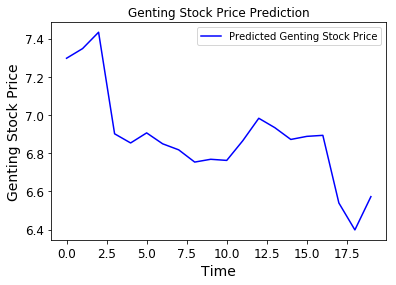

In [123]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
print(len(X_test[0]))
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(X_test.shape)
print(predicted_stock_price.shape)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
real_stock_price = []
for i in range(60, 80):
    real_stock_price.append(inputs[i-60:i, 0])    
real_stock_price = np.array(real_stock_price)
#print(real_stock_price)

#print(predicted_stock_price.shape)
#print(real_stock_prices.shape)
#real_stock_prices = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#real_stock_prices = real_stock_prices.reshape(-1,1)
#print(len(real_stock_prices))
#print(len(predicted_stock_price))

# Visualising the results
#plt.plot(real_stock_prices, color = 'red', label = 'Real Genting Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Genting Stock Price')
plt.title('Genting Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Genting Stock Price')
plt.legend()
plt.show()
#print(predicted_stock_price)
#print(test_set)

In [110]:
# https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
# Save the model
# regressor.save('Genting.h5')

In [108]:
# from keras.models import load_model
# load model from single file
# model = load_model('Genting.h5')
# make predictions


# Prediction

* https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f
* https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Time%20Series%20Prediction.ipynb

In [4]:
df_idx = pd.read_csv('data/GENTING_data_set.csv')
df_idx['Date'] = pd.to_datetime(df_idx["Date"])
clean_dataset(df_idx)
df_idx.head(10)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,10.14,10.10,10.16,10.08,6490000.0
2011-08-16,10.10,10.18,10.24,10.02,3160000.0
2011-08-17,10.04,10.10,10.10,10.02,5410000.0
2011-08-18,9.98,10.14,10.14,9.97,5350000.0
2011-08-19,9.70,9.85,9.85,9.65,11570000.0
2011-08-22,9.51,9.68,9.69,9.49,8520000.0
2011-08-23,9.70,9.55,9.70,9.40,6520000.0
2011-08-24,9.52,9.80,9.80,9.52,5090000.0
2011-08-25,9.78,9.55,9.78,9.54,6120000.0


In [140]:
#df_idx = df_idx.sort_index(axis=1, ascending=True)
#df_idx = df_idx.iloc[::-1]
#df_idx.head(10)

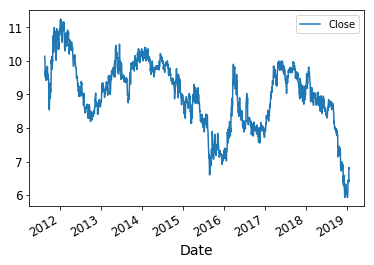

In [141]:
data = df_idx[['Close']]
data.plot(y='Close')

In [143]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2011 to %d"%(2011 + int(0.8*years)))

Total data: 7 years
80 percent data = 2011 to 2016


### Create training and test data

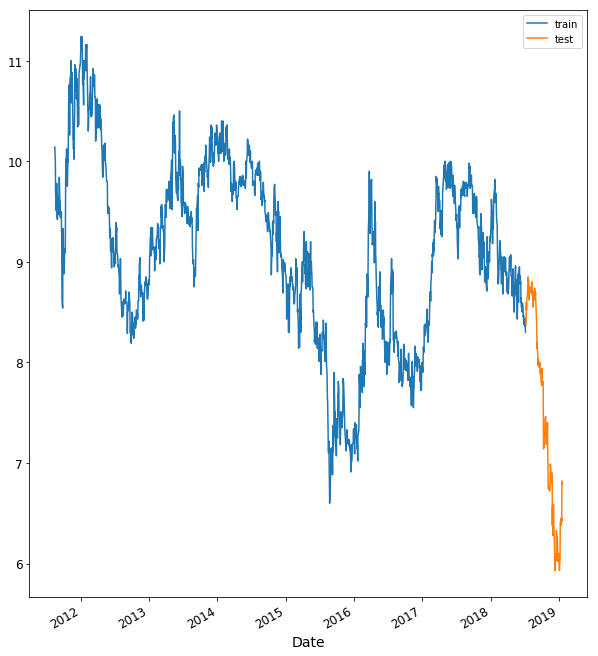

In [145]:
split_date = pd.Timestamp('07-07-2018')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

### Normalize the dataset

In [154]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [159]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

#print(train_sc_df)
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/Users/mengwangk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/mengwangk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/mengwangk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/mengwangk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [160]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (1689 x 1)
Test size: (130 x 1)


### Setup baseline model of SVM regressor

In [161]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/Users/mengwangk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mengwangk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


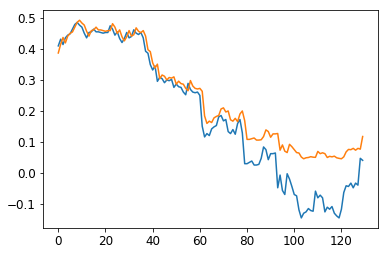

In [162]:
plt.plot(y_test)
plt.plot(y_pred)

In [5]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

NameError: name 'y_test' is not defined

### Build a neural network

In [165]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

#### 1 hidden layer with 1 neuron

In [166]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
1689/1689 [==============================] - 1s 385us/step - loss: 0.4264
Epoch 2/20
1689/1689 [==============================] - 0s 91us/step - loss: 0.2617
Epoch 3/20
1689/1689 [==============================] - 0s 96us/step - loss: 0.1573
Epoch 4/20
1689/1689 [==============================] - 0s 91us/step - loss: 0.0970
Epoch 5/20
1689/1689 [==============================] - 0s 91us/step - loss: 0.0637
Epoch 6/20
1689/1689 [==============================] - 0s 86us/step - loss: 0.0457
Epoch 7/20
1689/1689 [==============================] - 0s 98us/step - loss: 0.0360
Epoch 8/20
1689/1689 [==============================] - 0s 85us/step - loss: 0.0307
Epoch 9/20
1689/1689 [==============================] - 0s 114us/step - loss: 0.0277
Epoch 10/20
1689/1689 [==============================] - 0s 103us/step - loss: 0.0259
Epoch 11/20
1689/1689 [==============================] - 0s 92us/step - loss: 0.0248
Epoch 12/20
1689/1689 [==============================] - 0s 95us/step -

R-Squared: -0.861852


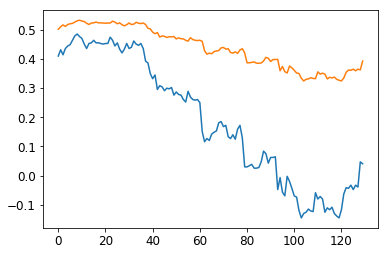

In [167]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

#### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [168]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
1689/1689 [==============================] - 1s 552us/step - loss: 0.0060
Epoch 2/20
1689/1689 [==============================] - 0s 132us/step - loss: 8.7685e-04
Epoch 3/20
1689/1689 [==============================] - 0s 128us/step - loss: 8.7520e-04
Epoch 4/20
1689/1689 [==============================] - 0s 128us/step - loss: 8.6916e-04
Epoch 5/20
1689/1689 [==============================] - 0s 130us/step - loss: 8.7585e-04
Epoch 6/20
1689/1689 [==============================] - 0s 126us/step - loss: 8.5982e-04
Epoch 7/20
1689/1689 [==============================] - 0s 129us/step - loss: 8.9772e-04
Epoch 8/20
1689/1689 [==============================] - 0s 125us/step - loss: 9.3420e-04
Epoch 9/20
1689/1689 [==============================] - 0s 129us/step - loss: 8.9702e-04
Epoch 10/20
1689/1689 [==============================] - 0s 131us/step - loss: 9.0239e-04
Epoch 11/20
1689/1689 [==============================] - 0s 134us/step - loss: 9.1155e-04
Epoch 12/20
1689/1689 [

R-Squared: 0.971311


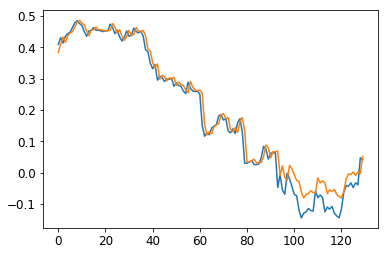

In [169]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

## LSTM

* https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/usd_to_inr_models.ipynb

In [6]:
df_idx = pd.read_csv('data/GENTING_data_set.csv')
df_idx['Date'] = pd.to_datetime(df_idx["Date"])
clean_dataset(df_idx)
df_idx.head(10)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,10.14,10.10,10.16,10.08,6490000.0
2011-08-16,10.10,10.18,10.24,10.02,3160000.0
2011-08-17,10.04,10.10,10.10,10.02,5410000.0
2011-08-18,9.98,10.14,10.14,9.97,5350000.0
2011-08-19,9.70,9.85,9.85,9.65,11570000.0
2011-08-22,9.51,9.68,9.69,9.49,8520000.0
2011-08-23,9.70,9.55,9.70,9.40,6520000.0
2011-08-24,9.52,9.80,9.80,9.52,5090000.0
2011-08-25,9.78,9.55,9.78,9.54,6120000.0


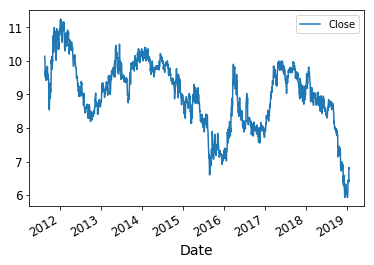

In [7]:
df = df_idx[["Close"]]
df.plot()

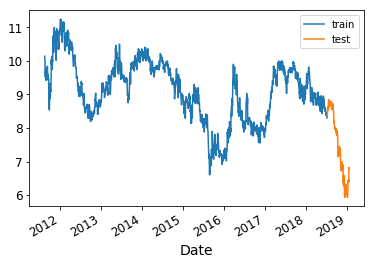

In [8]:
split_date = pd.Timestamp('07-07-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
1689/1689 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 2/200
1689/1689 [==============================] - 2s 1ms/step - loss: 0.0013
Epoch 3/200
1689/1689 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 4/200
1689/1689 [==============================] - 3s 1ms/step - loss: 0.0010
Epoch 5/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.9453e-04
Epoch 6/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.7888e-04
Epoch 7/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.7002e-04
Epoch 8/200
1689/1689 [==============================] - 3s 2ms/step - loss: 9.6463e-04
Epoch 9/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.6121e-04
Epoch 10/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.5901e-04
Epoch 11/200
1689/1689 [==============================] - 2s 1ms/step - loss: 9.5741e-04
Epoch 12/200
1689/1689 [======================

In [183]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.890
The Adjusted R2 score on the Train set is:	0.890

The R2 score on the Test set is:	0.810
The Adjusted R2 score on the Test set is:	0.808


In [184]:
model.save('ANN_NonShift.h5')

### Process the data for LSTM

In [188]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#print(X_tr_t)

[[[0.76293103]]

 [[0.75431034]]

 [[0.74137931]]

 ...

 [[0.38362069]]

 [[0.38793103]]

 [[0.39655172]]]


In [ ]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
1689/1689 [==============================] - 11s 6ms/step - loss: 0.0123
Epoch 2/200
1689/1689 [==============================] - 9s 5ms/step - loss: 0.0012
Epoch 3/200
1689/1689 [==============================] - 9s 5ms/step - loss: 9.8271e-04
Epoch 4/200
1689/1689 [==============================] - 9s 6ms/step - loss: 9.4336e-04
Epoch 5/200
1689/1689 [==============================] - 10s 6ms/step - loss: 9.3185e-04
Epoch 6/200
1689/1689 [==============================] - 9s 5ms/step - loss: 9.2672e-04
Epoch 7/200
1689/1689 [==============================] - 11s 6ms/step - loss: 9.2359e-04
Epoch 8/200
1689/1689 [==============================] - 11s 6ms/step - loss: 9.2125e-04
Epoch 9/200
1689/1689 [==============================] - 10s 6ms/step - loss: 9.1932e-04
Epoch 10/200
1689/1689 [==============================] - 10s 6ms/step - loss: 9.1763e-04
Epoch 11/200
1689/1689 [==============================] - 10s 6ms/step - loss: 9.1607e-04
Epoch 12/200
1689/1689 [=======